In [25]:
from ipynb.fs.defs._06_Probability import normal_cdf, inverse_normal_cdf
import math, random

In [26]:
def normal_approximation_to_binomial(n, p):
    """finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

In [27]:
# the normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

# it's above the threshold if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [28]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2

    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [29]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print("mu_0", mu_0)
print("sigma_0", sigma_0)
print("normal_two_sided_bounds(0.95, mu_0, sigma_0)", normal_two_sided_bounds(0.95, mu_0, sigma_0))
print()

mu_0 500.0
sigma_0 15.811388300841896
normal_two_sided_bounds(0.95, mu_0, sigma_0) (469.01026640487555, 530.9897335951244)



In [30]:
print("power of a test")
print("95% bounds based on assumption p is 0.5")

lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print("lo", lo)
print("hi", hi)

print("actual mu and sigma based on p = 0.55")
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print("mu_1", mu_1)
print("sigma_1", sigma_1)
# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.887

print("type 2 probability", type_2_probability)
print("power", power)
print()

print("one-sided test")
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print("hi", hi) # is 526 (< 531, since we need more probability in the upper tail)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability # = 0.936
print("type 2 probability", type_2_probability)
print("power", power)
print()

power of a test
95% bounds based on assumption p is 0.5
lo 469.01026640487555
hi 530.9897335951244
actual mu and sigma based on p = 0.55
mu_1 550.0
sigma_1 15.732132722552274
type 2 probability 0.11345199870463285
power 0.8865480012953671

one-sided test
hi 526.0073585242053
type 2 probability 0.06362051966928273
power 0.9363794803307173



In [31]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is above x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is below x
        return 2 * normal_probability_below(x, mu, sigma)

In [32]:
print("two_sided_p_value(529.5, mu_0, sigma_0)", two_sided_p_value(529.5, mu_0, sigma_0))

two_sided_p_value(529.5, mu_0, sigma_0) 0.06207721579598857


In [33]:
def count_extreme_values():
    extreme_value_count = 0
    for _ in range(100000):
        num_heads = sum(1 if random.random() < 0.5 else 0    # count # of heads
                        for _ in range(1000))                # in 1000 flips
        if num_heads >= 530 or num_heads <= 470:             # and count how often
            extreme_value_count += 1                         # the # is 'extreme'

    return extreme_value_count / 100000

count_extreme_values()

0.06155

In [34]:
print("two_sided_p_value(531.5, mu_0, sigma_0)", two_sided_p_value(531.5, mu_0, sigma_0))

two_sided_p_value(531.5, mu_0, sigma_0) 0.046345287837786575


In [35]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below
print("upper_p_value(525, mu_0, sigma_0)", upper_p_value(524.5, mu_0, sigma_0))
print("upper_p_value(527, mu_0, sigma_0)", upper_p_value(526.5, mu_0, sigma_0))
print()

upper_p_value(525, mu_0, sigma_0) 0.06062885772582083
upper_p_value(527, mu_0, sigma_0) 0.04686839508859242



In [36]:
def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

print("P-hacking")

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

print(num_rejections, "rejections out of 1000")
print()

P-hacking
46 rejections out of 1000



In [37]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [38]:
print("A/B testing")

z = a_b_test_statistic(1000, 200, 1000, 180)
print("a_b_test_statistic(1000, 200, 1000, 180)", z)
print("p-value", two_sided_p_value(z))

z = a_b_test_statistic(1000, 200, 1000, 150)
print("a_b_test_statistic(1000, 200, 1000, 150)", z)
print("p-value", two_sided_p_value(z))

A/B testing
a_b_test_statistic(1000, 200, 1000, 180) -1.1403464899034472
p-value 0.254141976542236
a_b_test_statistic(1000, 200, 1000, 150) -2.948839123097944
p-value 0.003189699706216853


In [39]:
def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    # if x < 0 or x > 1:          # no weight outside of [0, 1]
    #     return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

### Bayesian Inference

In [40]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [41]:
import scipy.stats as ss

def plot_beta(x_range, a, b, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the f distribution function for a given x range, a and b
    If mu and sigma are not provided, standard beta is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.beta.cdf(x, a, b, mu, sigma)
    else:
        y = ss.beta.pdf(x, a, b, mu, sigma)
    plt.plot(x, y, **kwargs)

In [42]:
def flip_coin(size=10, random_state=42):
    np.random.seed(random_state)
    flips = np.random.randint(0, 1+1, size)
    h = np.sum(flips == 0)
    t = np.sum(flips == 1)
    return h, t

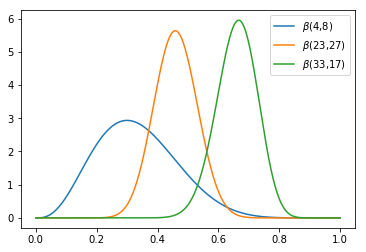

In [43]:
h_1, t_1 = 3, 7

a_1, b_1 = 1, 1
a_2, b_2 = 20, 20
a_3, b_3 = 30, 10

a_1, b_1 = a_1 + h_1, b_1 + t_1
a_2, b_2 = a_2 + h_1, b_2 + t_1
a_3, b_3 = a_3 + h_1, b_3 + t_1

plot_beta(x, a_1, b_1, label=rf'$\beta$({a_1},{b_1})')
plot_beta(x, a_2, b_2, label=rf'$\beta$({a_2},{b_2})')
plot_beta(x, a_3, b_3, label=rf'$\beta$({a_3},{b_3})')

plt.legend();

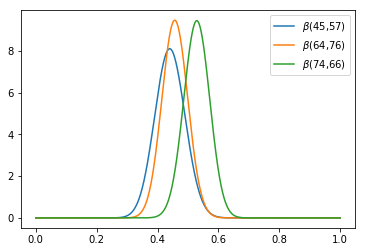

In [44]:
h_2, t_2 = flip_coin(100)


a_1, b_1 = 1, 1
a_2, b_2 = 20, 20
a_3, b_3 = 30, 10

a_1, b_1 = a_1 + h_2, b_1 + t_2
a_2, b_2 = a_2 + h_2, b_2 + t_2
a_3, b_3 = a_3 + h_2, b_3 + t_2

plot_beta(x, a_1, b_1, label=rf'$\beta$({a_1},{b_1})')
plot_beta(x, a_2, b_2, label=rf'$\beta$({a_2},{b_2})')
plot_beta(x, a_3, b_3, label=rf'$\beta$({a_3},{b_3})')

plt.legend();